In [46]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit
import pickle

In [47]:
# RUN="14180"
# RUN="14498"
# RUN="13850"
RUN="14498"

mode = "deconv"

time_range = 50,750
fit_multiplier = 1

if (RUN =="14180"):
    PE_to_MeV = 4.1107552268907513e-07
    nbins = 10
    bin_range = 4000

if (RUN =="13850"):
    PE_to_MeV = 4.380634467274111e-07
    nbins = 10
    bin_range = 4000

if (RUN == "13859"):
    PE_to_MeV = 5.80816646495761e-07
    nbins = 10
    bin_range = 25000
    time_range = 300,750
    fit_multiplier = 10

if (RUN =="14498"):
    PE_to_MeV = 3.1225103356461257e-07
    nbins = 10
    bin_range = 500

In [48]:
file = f"../data/analysis/Run_{RUN}_Filtered.h5"
# file = f"../data/analysis/Run_{RUN}_FilteredRaw.h5"

datafile = f"../data/analysis/Run_{RUN}_FilteredC.h5"

# lifetime_df = pd.read_hdf(f"../maps/LifetimeMap_Run_{RUN}.h5", "map")

data_properties_lt = pd.read_hdf(f"../data/analysis/Properties_Run_{RUN}.h5", "data_properties_lt")

with open(f"../data/analysis/Run_{RUN}_Histograms.pkl", 'rb') as pickle_file:
    histogram2D_df = pickle.load(pickle_file)
    histogram1D_df = pickle.load(pickle_file)
    total_hist = pickle.load(pickle_file)

display(data_properties_lt)
print("Num events:", len(data_properties_lt.event.unique()))


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R,cath_areaC
0,17351,7.075970e+05,7.317886e+05,1602.887048,36.162972,2524.901667,16.933063,1.730124e+09,-999.000,2.366650,...,333.333333,-222.222222,7_2,42208.920901,17491912.897136,333.333333,-222.222222,0.223637,431.169000,0.000011
1,17358,9.804880e+06,9.791496e+06,1612.569223,370.746339,2531.626389,15.224785,1.730124e+09,-999.000,5.401290,...,-222.222222,-444.444444,2_0,0,0,-222.222222,-444.444444,0.000000,458.547496,0.000114
4,17379,2.475571e+06,2.536587e+06,1606.024741,185.614031,2527.791667,15.768368,1.730124e+09,1322.300,6.234440,...,-111.111111,444.444444,3_8,0,0,-111.111111,444.444444,0.000000,466.287456,0.000060
5,17386,1.423254e+07,1.428373e+07,1615.056949,447.775449,2510.681667,5.940399,1.730124e+09,1281.025,5.976276,...,333.333333,222.222222,7_6,60140.008604,16194140.304916,333.333333,222.222222,5.082175,434.790871,0.000144
6,17393,1.810995e+07,1.843112e+07,1606.071545,291.569860,2528.879167,10.918723,1.730124e+09,95.625,2.258617,...,-222.222222,-222.222222,2_2,70833.518102,16742187.38516,-222.222222,-222.222222,6.131485,324.152096,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,19369,1.757356e+07,1.725162e+07,1611.111311,428.097805,2523.941176,16.199269,1.730124e+09,655.850,4.591757,...,111.111111,0.000000,5_4,42251.287734,17932251.634297,111.111111,0.000000,5.634307,105.167872,0.000136
15472,19376,1.633106e+07,1.685846e+07,1604.901445,122.552331,2517.045000,12.175788,1.730124e+09,67.325,1.689437,...,-222.222222,111.111111,2_5,37816.929231,17710668.245807,-222.222222,111.111111,5.229098,276.400970,0.000039
15474,19390,1.223586e+07,1.223876e+07,1614.325710,475.245738,2519.226250,16.226891,1.730124e+09,1325.450,6.110655,...,333.333333,-111.111111,7_3,54735.208411,17562931.576247,333.333333,-111.111111,4.040438,329.374432,0.000153
15475,19397,1.834463e+07,2.293836e+07,1604.155293,67.548117,2513.620000,11.334438,1.730124e+09,-999.000,1.925828,...,111.111111,111.111111,5_5,28279.93722,18007880.467929,111.111111,111.111111,5.566457,142.712845,0.000021


Num events: 10725


In [49]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

# Line
def Line(x, m, c):
    return m*x+c

# Define the exponential decay function
def exp_decay(t, q, tau, intercept):
    return intercept + q * np.exp(-t / tau)

### Cathode Photoelectric Effect

0.12961562737936805Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 1.6675383826379169


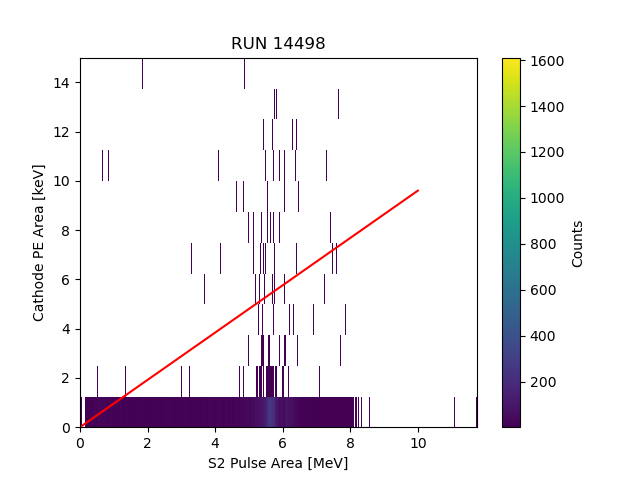

In [50]:
# 1. Create the 2D histogram
%matplotlib widget

data_properties_lt_radial = data_properties_lt[data_properties_lt.R < 500]

# hist, xedges, yedges = np.histogram2d(data_properties_active.S2_area, data_properties_active.cath_area, bins=100)
hist, xedges, yedges = np.histogram2d(data_properties_lt_radial.S2_areaC, data_properties_lt_radial.cath_areaC*1000, bins=[500, 1000])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Cathode PE Area [keV]")
# plt.ylim(0,2e6)
plt.ylim(0,15)

plt.title(f"RUN {RUN}")

S2_arr = np.linspace(0,10, 100)

# Perform the curve fit
# params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bounds = ([1e8, 1e3], [4.5e8, 100e3]))
params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC, data_properties_lt_radial.cath_areaC*1000)

# Extract the fitted parameters
m, c = params

print(m,c)

plt.plot(S2_arr, Line(S2_arr, 0.96, 0), c = "red")


Text(0, 0.5, 'Cathode PE Area [keV]')

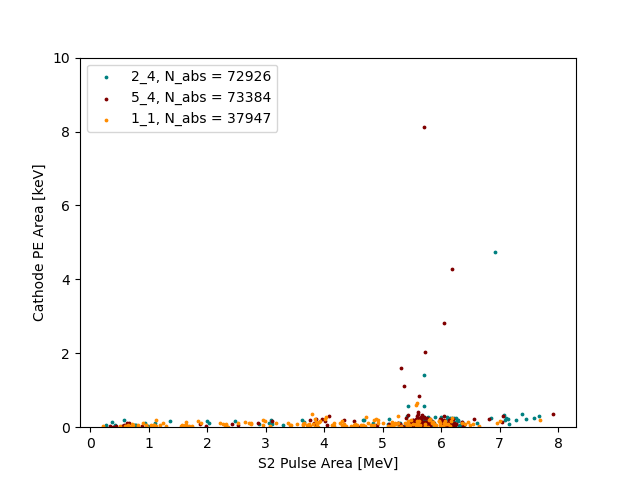

In [56]:
# Here we look at different bins which have different absorbed photon numbers.
# This tell us we need to apply some geometrical correction based on this simulation. 

plt.figure()

# for bin_ in data_properties_lt.bin_id.unique(): 
temp_df = data_properties_lt[data_properties_lt.bin_id == "2_4"]
plt.scatter(temp_df.S2_areaC, temp_df.cath_areaC * 1000, color = "Teal", label = "2_4, N_abs = 72926", s=3)
temp_df = data_properties_lt[data_properties_lt.bin_id == "5_4"]
plt.scatter(temp_df.S2_areaC, temp_df.cath_areaC * 1000, color = "Maroon", label = "5_4, N_abs = 73384", s=3)
temp_df = data_properties_lt[data_properties_lt.bin_id == "1_1"]
plt.scatter(temp_df.S2_areaC, temp_df.cath_areaC * 1000, color = "DarkOrange", label = "1_1, N_abs = 37947", s=3)
plt.ylim(0,10)

plt.legend()
plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Cathode PE Area [keV]")


### S2 Tails

In [57]:
display(histogram1D_df)
nevents = len(histogram1D_df.event.unique())
print("Num events:",nevents)
result = histogram1D_df.groupby('centers')['counts'].agg(['mean', 'std']).reset_index()
display(result)

if (RUN=="13859"):
    result = result[result.centers>275]


,event,counts,centers
0,19430,97.526214,75.0
1,19430,52.503575,125.0
2,19430,32.057807,175.0
3,19430,29.494587,225.0
4,19430,24.961177,275.0
...,...,...,...
424,10321,7.234807,475.0
425,10321,34.999910,525.0
426,10321,13.437491,575.0
427,10321,17.163881,625.0


Num events: 3548


,centers,mean,std
0,75.0,223.330992,422.065393
1,125.0,119.231462,173.872945
2,175.0,98.799384,466.589321
3,225.0,75.514212,105.651819
4,275.0,65.326602,95.000688
5,325.0,60.516172,180.355579
6,375.0,56.940090,250.647297
7,425.0,48.821544,62.062114
8,475.0,47.236356,102.909855
9,525.0,42.608276,69.532987


Text(0, 0.5, 'Energy [eV/MeV]')

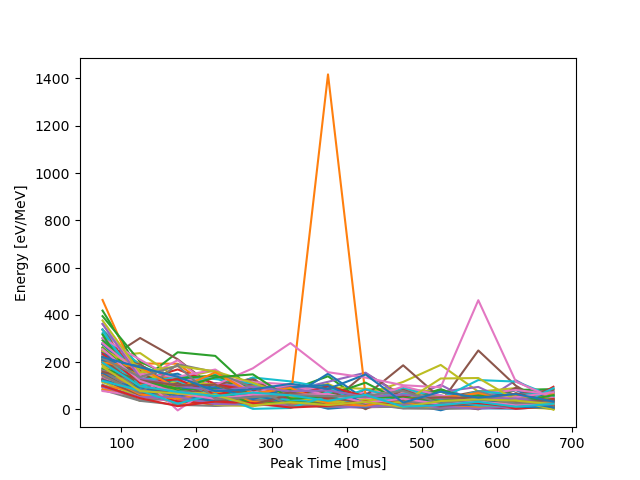

In [58]:
plt.figure()

# plt.errorbar(result.centers, result["mean"]/nevents,yerr=result["std"]/nevents)

for index, evt in enumerate(histogram1D_df.event.unique()):

    if index > 100:
        break

    temp_df = histogram1D_df[histogram1D_df.event ==evt]

    plt.plot(temp_df.centers, temp_df.counts)
    
plt.xlabel('Peak Time [mus]')
plt.ylabel('Energy [eV/MeV]')

283.3565239889752 109.59103968106804 40.85599867298439


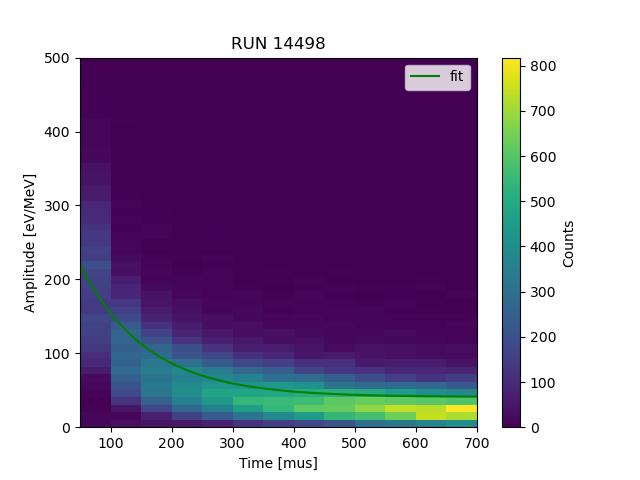

In [69]:

%matplotlib widget

fig, ax = plt.subplots()

# 2. Mask zero bins
# total_hist = np.ma.masked_where(total_hist <  40, total_hist)  # Mask bins where the count is zero
# total_hist = np.ma.masked_where(total_hist > 700, total_hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

bins = np.arange(50, 750, 50)
min_value = np.min(total_hist)  # Get the minimum value
max_value = np.max(histogram1D_df.counts)  # Get the maximum value
_, xedges, yedges = np.histogram2d([0,750], [0,0.18], bins=[bins, np.linspace(0, bin_range,50)])

pcm = ax.pcolormesh(xedges, yedges, total_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [eV/MeV]")

plt.title(f"RUN {RUN}")

# plt.errorbar(result.centers, result["mean"],yerr=result["std"],color="red")

# plt.show()



times = np.linspace(time_range[0],time_range[1]-50, 100)

# Perform the curve fit
params, covariance = curve_fit(exp_decay, result.centers, result["mean"],sigma=result["std"], absolute_sigma=True, p0=[10000, 100, 0 ], bounds = ([0, 10, 0], [11000*fit_multiplier, 5e3,50*fit_multiplier]))

# Extract the fitted parameters
q_fit, tau_fit, intercept = params

plt.plot(times, exp_decay(times, q_fit, tau_fit, intercept), c = "green", label="fit")

print(q_fit, tau_fit, intercept)


plt.legend()

Text(0.5, 1.0, 'RUN 14498')

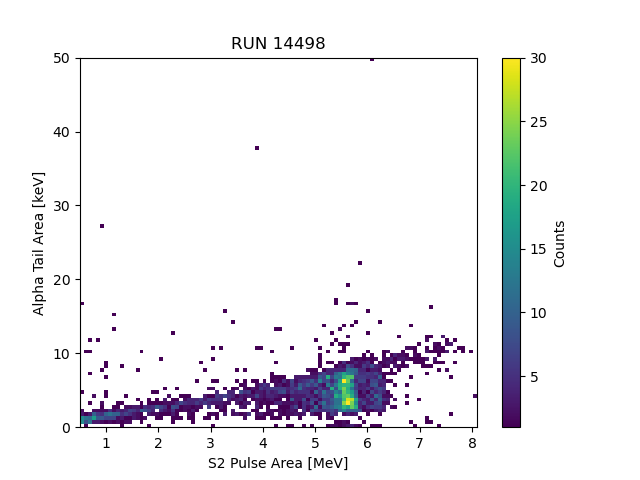

In [60]:

hist, xedges2, yedges2 = np.histogram2d(histogram2D_df.S2_areas,histogram2D_df.tail_energy/1000, bins=[100, 100])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges2, yedges2, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Alpha Tail Area [keV]")
# plt.ylim(0,35)

plt.title(f"RUN {RUN}")

# plt.plot(S2_arr, Line(S2_arr, 2.5, 0), c = "red")

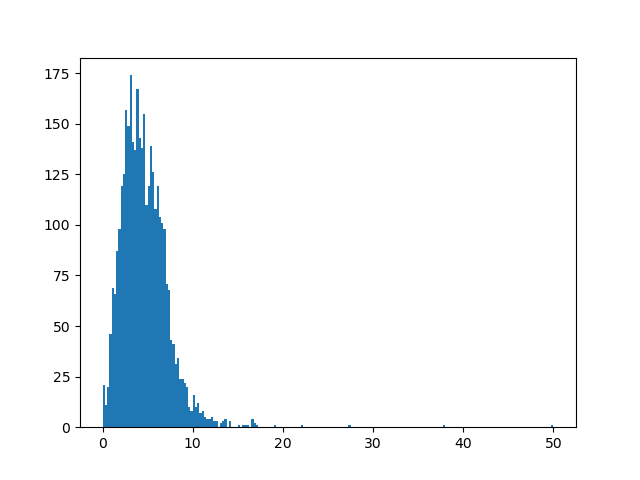

In [66]:
plt.figure()

plt.hist(histogram2D_df.tail_energy/1000, bins = 200);

In [61]:
# Get the total area 

from scipy.integrate import quad

# Define the parameters
q0 = 1700
Tau = 300

# Define the function
def q(t):
    return q0 * np.exp(-t / Tau)

# Calculate the integral from 0 to 900
integral_value, _ = quad(q, 0, 800)
print(integral_value)


474563.4398763713
